In [22]:
# importing Qiskit
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.visualization import plot_histogram

In [23]:
switching3x3 = {
    0: [0, 1, 3],
    1: [0, 1, 2, 4],
    2: [1, 2, 5],
    3: [0, 3, 4, 6],
    4: [1, 3, 4, 5, 7],
    5: [2, 4, 5, 8],
    6: [3, 6, 7],
    7: [4, 6, 7, 8],
    8: [5, 7, 8]
}


In [24]:
def init(x):
    n = int(len(x)**(1/2))
    f_in = QuantumRegister(len(x), name='x')
    f_out = QuantumRegister(len(x), name='y')
    f_oracle = QuantumRegister(1, name='o')
    f_res = ClassicalRegister(len(x), name='c')
    f = []
    f.append(f_in)
    f.append(f_out)
    f.append(f_oracle)
    f.append(f_res)
    cq = QuantumCircuit(f_in, f_out, f_oracle, f_res) 
    cq.x(f_oracle)
    cq.h(f_oracle)
    for i in range(len(x)):
        if x[i]:
            cq.x(i)
    cq.h(f_out)
    cq.barrier()
    return cq, f
    
def function(cq, f):
    for n, lights in switching3x3.items():
        for i in lights:
            cq.cx(f[1][i],f[0][n])
    cq.barrier()
    return cq
    
def oracle(cq, f):
    cq.x(f[0])
    cq.mcx(f[0], f[2])
    cq.x(f[0])
    cq.barrier()
    return cq
    
def diffusion(cq, f):
    cq.h(f[1])
    cq.x(f[1])
    cq.h(f[1][-1])
    cq.mcx(f[1][0:-1], f[1][-1])
    cq.h(f[1][-1])
    cq.x(f[1])
    cq.h(f[1])
    cq.barrier()
    return cq


def lightsout_iter(cq,f):
    cq = function(cq,f)
    cq = oracle(cq,f)
    cq = function(cq,f)
    cq = diffusion(cq,f)
    return cq
    
def lightsout_cq(x):
    cq, f = init(x)
    for i in range(16):
        cq = lightsout_iter(cq,f)
    cq.h(f[2])
    cq.x(f[2])
    cq.barrier()
    cq.measure(f[1],f[3])
    return cq

In [25]:
cq = lightsout_cq([0,1,0,1,1,1,0,1,0])
cq = cq.reverse_bits() 
#print(cq.draw(output="mpl", style="clifford"))

Figure(640x480)


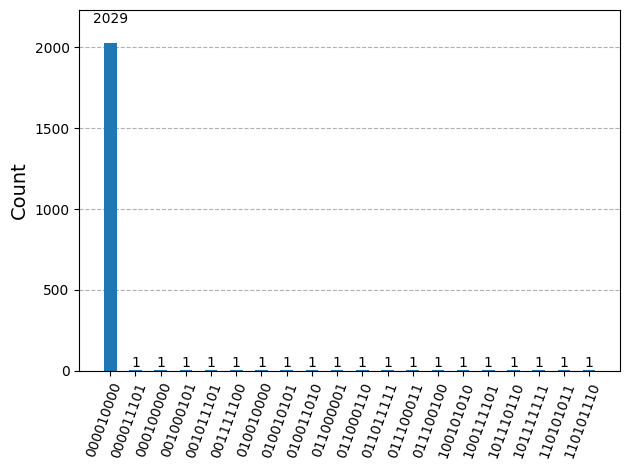

In [27]:
sim = AerSimulator()
job = sim.run(cq, shots = 2048)
results = job.result()
answer = results.get_counts()
#print(answer)
print(plot_histogram(answer))

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="", set_as_default=True, overwrite=True)

# Load saved credentials
service = QiskitRuntimeService()

In [7]:
from qiskit import QuantumCircuit
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
qc = cq
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
#qc.draw("mpl", style="clifford")

In [8]:
from qiskit.quantum_info import Pauli
 
ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')
I = Pauli('IIIIIIIIIIIIIIIIIII')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
 
service = QiskitRuntimeService()

# Run the job locally on a fake backend
fake_backend = FakeBrisbane()
pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=0)
isa_qc = pm.run(qc)

observables = [I]
isa_observables = [observable.apply_layout(isa_qc.layout) for observable in observables]

# Run on the least-busy backend you have access to
backend = service.least_busy(simulator=False, operational=True)
print(f"Running on backend: {backend}")
 
# Create an Estimator object
estimator = Estimator(mode=fake_backend)
 
# Submit the circuit to Estimator
job = estimator.run([(isa_qc, isa_observables)])
print(f"job id: {job.job_id()}")

# Once the job is complete, get the result
job.result()[0].data.evs  # expectation values

Running on backend: <IBMBackend('ibm_brisbane')>
job id: 05eefae2-7706-4f18-978d-d657c5f8fe55


In [ ]:
job_id = "614c6121-fd8a-4350-8ee5-217d6d752af2"

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load saved credentials
service = QiskitRuntimeService()
job = service.job(job_id)

In [ ]:
print(job.result())
results = job.result()
answer = results.get_counts()
print(answer)
print(plot_histogram(answer))